In [2]:
#import libraries
import os
from osgeo import gdal
import datetime
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import subprocess
from wetspass_inputs_funcs import * #import all functions from wetspass_inputs_funcs.py

In [3]:
#set the font type
plt.rcParams['font.family'] = 'Arial'

#### Prepare gridded Wetspass data for the study area


For PET, create a df of required meteorological variables: RHmean, Tmax, Tmin and wind speed.    
Also include a column for the date to get the day of the year.  
Solar radiation is computed from the location and elevation of the studya area.  

In [4]:
#read in the inputs
src_path=r"W:/VUB/IP_2024/data/weather_data"

rainfall=pd.read_csv(src_path+"/1.pcp", delim_whitespace=True, skiprows=3,header=None, names=['year', 'jday','rain'])
hmd=pd.read_csv(src_path+"/1.hmd", delim_whitespace=True, skiprows=3,header=None, names=['year', 'jday','hmd'])
temp=pd.read_csv(src_path+"/1.tmp", delim_whitespace=True, skiprows=3,header=None, names=['year', 'jday','Tmax','Tmin'])
wind=pd.read_csv(src_path+"/1.wnd", delim_whitespace=True, skiprows=3,header=None, names=['year', 'jday','wind'])

#assign dates to files
#resample to monthly
#write to grids
#compute pet\

#### Assign dates to dataframes

In [5]:
#assign dates to dataframes
def convert_to_date_vectorized(df):
    # Vectorized operation to convert year and Julian day to datetime
    df['date'] = pd.to_datetime(df['year'].astype(int), format='%Y') + pd.to_timedelta(df['jday'].astype(int) - 1, unit='D')
    df.set_index('date', inplace=True)

dfs_list = [rainfall, hmd, temp, wind]

for df in dfs_list:
    convert_to_date_vectorized(df)

#### Concatenate dataframes (Tmax, Tmin, wind, hmd) for PET computations

In [6]:
#calculate Tmean and convert hmd to percentage
# Identifying rows where Tmax is less than Tmin
mask = temp['Tmax'] < temp['Tmin']

# # Swapping Tmax and Tmin for these rows
temp.loc[mask, ['Tmax', 'Tmin']] = temp.loc[mask, ['Tmin', 'Tmax']].values
# # Calculate Tmean
temp['Tmean']=temp[['Tmax','Tmin']].mean(axis=1)
#convert hmd to percentage
hmd['hmd_perc']=hmd['hmd']*100

#concatenate dfs required for pet calculation
df_pet_vars=pd.concat([temp['jday'],temp['year'],temp['Tmax'],temp['Tmin'],temp['Tmean'],hmd['hmd_perc'], wind['wind']],axis=1, join='inner')
df_pet_vars.head()

,jday,year,Tmax,Tmin,Tmean,hmd_perc,wind
date,,,,,,,
1970-01-01,1,1970,-0.7400,-8.2917,-4.51585,84.44,3.273333
1970-01-02,2,1970,3.5383,-8.7367,-2.59920,94.65,6.701667
1970-01-03,3,1970,3.4050,-1.3717,1.01665,96.30,2.721667
1970-01-04,4,1970,1.8833,-2.5850,-0.35085,90.65,2.365000
1970-01-05,5,1970,1.8967,-3.5450,-0.82415,92.38,3.585000


#### Define static PET variables and compute daily PET

In [7]:
#static inputs for pet calculation
lat=51.17 #latitude of study area in degrees
elev=13.36 #average elevation of study area in meters
z=2.0 #assumed height of wind speed measurement in meters

"""
Compute pet, pass the variables in the same order as the function: 
Compute_penman_monteith_ETo(latitude, day_of_year, elevation, Tmax, Tmin, Tmean, RHmean, uz, z):
"""

df_pet_vars['pet']=df_pet_vars.apply(lambda row: compute_penman_monteith_ETo(lat,
                                     row['jday'], elev, row['Tmax'], row['Tmin'],
                                     row['Tmean'], row['hmd_perc'], row['wind'], z), axis=1)

In [ ]:
df_pet_vars['pet'].to_csv(src_path+"/pet.csv")

In [8]:
df_pet_vars.head()

,jday,year,Tmax,Tmin,Tmean,hmd_perc,wind,pet
date,,,,,,,,
1970-01-01,1,1970,-0.7400,-8.2917,-4.51585,84.44,3.273333,0.408286
1970-01-02,2,1970,3.5383,-8.7367,-2.59920,94.65,6.701667,0.450343
1970-01-03,3,1970,3.4050,-1.3717,1.01665,96.30,2.721667,0.230127
1970-01-04,4,1970,1.8833,-2.5850,-0.35085,90.65,2.365000,0.320614
1970-01-05,5,1970,1.8967,-3.5450,-0.82415,92.38,3.585000,0.317331


#### (Optional) Resample to monthly PET

In [10]:
#pivot the dataframe to days of each year
df_pet_month_mean=df_pet_vars.resample('M').mean()
df_pet_month_sum=df_pet_vars.resample('M').sum()
df_pet_month_mean['year']=df_pet_month_mean.index.year
df_pet_month_sum['year']=df_pet_month_sum.index.year

df_pet_month_mean['month']=df_pet_month_mean.index.month
df_pivot=df_pet_month_mean.pivot_table(index=['month'], columns='year', values='pet')

In [54]:
df_pet_month_sum.tail()

,jday,year,Tmax,Tmin,Tmean,hmd_perc,wind,pet
date,,,,,,,,
2021-08-31,7068,2021,661.7267,429.6267,545.67670,2420.49,100.890000,97.101369
2021-09-30,7755,2021,648.9433,344.5766,496.75995,2321.21,83.901667,80.339605
2021-10-31,8959,2021,490.6652,230.3533,360.50925,2564.41,109.928333,46.474753
2021-11-30,9585,2021,298.9017,102.3034,200.60255,2605.87,90.688333,22.129724
2021-12-31,10850,2021,252.2236,97.6100,174.91680,2750.21,110.943333,17.826120


### Plotting

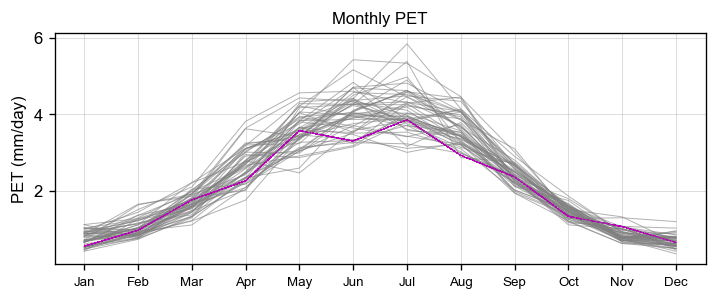

In [55]:
fig, ax = plt.subplots(figsize=(7, 2.5), dpi=120)

# Plotting the data for selected years
for i in range(len(df_pivot.columns)):
    ax.plot(df_pivot.iloc[:,7], label=df_pivot.columns[0], linestyle='dashed', color='m', linewidth=0.4)
    ax.plot(df_pivot.iloc[:,i], linewidth=0.6, alpha=0.6, color='gray')
    # Setting x-ticks and x-tick labels
    ax.set_xticks(np.arange(1, 13, 1))
    ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=8)
    ax.grid(alpha=0.5, linewidth=0.5)
    ax.set_title('Monthly PET', fontsize=10)
    ax.set_ylabel('PET (mm/day)')

    # Adding a legend
#plt.legend(ncol=3)
plt.show()

### Convert monthly dataframes to arrays


In [56]:
#call the relevant gridded_input function to convert data to arrays
met_vars=['pcp', 'hmd', 'tmp', 'wnd']
pathlist=[f"W:/VUB/IP_2024/data/weather_data/1.{var}" for var in met_vars]

variable='rain'
start_date='2003-09-01'
resample_freq='M'
min_x, max_x, min_y, max_y = 159600, 163350, 205500, 207200
gridsize=10


#demo use: gridded_temp(df_path:Path, resample_freq:str,min_x, max_x,min_y,max_y, gridsize):

rainfall_arrays=gridded_input(pathlist[0], 'rain',start_date,resample_freq,min_x, max_x,min_y,max_y, gridsize)
temp_arrays=gridded_temp(pathlist[2],start_date,resample_freq,min_x, max_x,min_y,max_y, gridsize)
wind_arrays=gridded_input(pathlist[3],  'wind',start_date,resample_freq,min_x, max_x,min_y,max_y, gridsize)


#for pet arrays, the function takes in a dataframe not a path
#demo use: gridded_pet(df:pd.DataFrame, variable:str,resample_freq:str,min_x, max_x,min_y,max_y, gridsize:int):
pet_arrays=gridded_pet(df_pet_vars, 'pet',start_date,resample_freq,min_x, max_x,min_y,max_y, gridsize)

#for snow, all values are 0
snow_arrays=gridded_input(pathlist[0], 'rain',start_date,resample_freq,min_x, max_x,min_y,max_y, gridsize)
for i in range(len(snow_arrays)):
    snow_arrays[i][:] = 0

### Write arrays to ascii files

In [ ]:
#temp
#array_to_ascii_grid(array_list, start_date, var, units, gridx, gridy, dest_folder):
start_date='2003-09-01'
dest_folder=r"W:/VUB/main_research/data/molenbeek_bgk/wetspass_input/maps"
gridx = np.arange(159600, 163350, 10,dtype=np.float32) 
gridy = np.arange(207200,205500,-10, dtype=np.float32)
crs="EPSG:31370"

array_to_ascii_grid(temp_arrays, start_date,'temp','degree celcius', gridx, gridy,crs, dest_folder)
array_to_ascii_grid(rainfall_arrays, start_date,'rain','mm', gridx, gridy,crs, dest_folder)
array_to_ascii_grid(wind_arrays, start_date,'wind','mm/s', gridx, gridy, crs,dest_folder)
array_to_ascii_grid(pet_arrays, start_date,'pet','mm/month', gridx, gridy, crs,dest_folder)
array_to_ascii_grid(snow_arrays, start_date,'snow','mm', gridx, gridy, crs,dest_folder)

In [58]:
dest_folder=r"W:\VUB\main_research\model_sims\wetspass\inputs\Maps"

In [59]:
#remove the metadata files(.xml) from the subfolders
for root, dirs, files in os.walk(dest_folder):
        for file in files:
            if file.endswith('.xml'):
                os.remove(os.path.join(root, file))
            else:
                continue

In [29]:
pet_dataset=array_to_ascii_grid(pet_arrays, start_date,'pet','mm/month', gridx, gridy, crs,dest_folder)

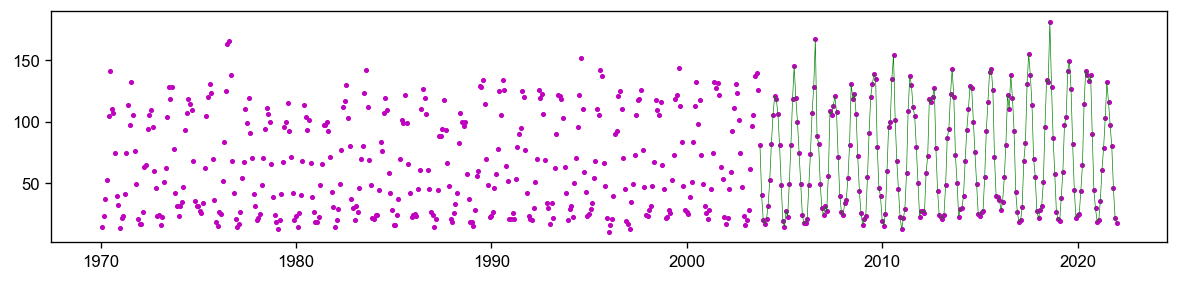

In [30]:
#validate the output
fig, ax = plt.subplots(figsize=(12, 2.5), dpi=120)
pet_random_grid=pet_dataset.sel(lon=162000, lat=206000, method='nearest')
df=pet_random_grid['pet'].to_dataframe().drop(columns=['lat', 'lon'])
plt.plot(df.index, df['pet'], label='gridded pet', color='g', linewidth=0.4)
plt.scatter(df_pet_month_sum.index, df_pet_month_sum['pet'], label='computed pet', color='m', linewidth=0.8, s=5)

### Rainy days per month, degree days per month

In [36]:
df_path_rain=r"W:\VUB\main_research\data\molenbeek_bgk\obs_data\weather_data\1.pcp"
df_path_temp=r"W:\VUB\main_research\data\molenbeek_bgk\obs_data\weather_data\1.tmp"
start_date='2003-09-01'
resample_freq='M'
outpath=r"W:\VUB\main_research\data\molenbeek_bgk\wetspass_input\tables"

rainydays=rainy_days_permonth(df_path_rain, start_date, 'M',outpath)
degreedays=degree_days_permonth(df_path_temp, start_date,'M', outpath)

#### Average intensity

Rain intensity is defined as average rainfall intensity during rainy days with rainfall >1mm

In [37]:
rain_stat=rainy_days_permonth(df_path_rain, start_date, 'M',outpath)

average_intensity=rain_stat[2]
print(average_intensity.mean())

0.24909797451008567


In [14]:
rain=pd.read_csv(r"W:\VUB\main_research\data\molenbeek_bgk\obs_data\weather_data\1.pcp", delim_whitespace=True, skiprows=3,header=None, names=['year', 'jday','rain'])
rain['date'] = pd.to_datetime(rain['year'].astype(int).astype(str) + rain['jday'].astype(int).astype(str), format='%Y%j')
#set zero values to a very low number
rain['rain'] = np.where(rain['rain'] == 0, 0.0001, rain['rain'])
rain.set_index('date', inplace=True)

#set start date to match the start date of the gridded data (groundwater)
rain=rain[start_date:]
rain['rainy_days'] = np.where(rain['rain'] > 1, 1, 0)
rainy_days=rain['rainy_days'].resample('M').sum().reset_index(drop=True)
rainy_days.index += 1 #start index from 1


In [13]:
rain

,year,jday,rain,rainy_days
date,,,,
2003-09-01,2003,244,1.5517,1
2003-09-02,2003,245,0.0050,0
2003-09-03,2003,246,0.0350,0
2003-09-04,2003,247,0.0001,0
2003-09-05,2003,248,0.0200,0
...,...,...,...,...
2021-12-27,2021,361,2.4167,1
2021-12-28,2021,362,12.3467,1
2021-12-29,2021,363,2.6333,1


In [11]:
rainy_days

1       9
2       9
3      11
4      12
5      18
       ..
216    12
217     4
218    14
219    13
220    14
Name: rainy_days, Length: 220, dtype: int32

In [12]:
rain_month=rain['rain'].resample('M').sum().reset_index(drop=True)
rain_month.index += 1 #start index from 1

#intensity in mm/hr
average_intensity=rain_month/rainy_days/24
#get rid of inf values
average_intensity=average_intensity.replace([np.inf, -np.inf], np.nan)

average_intensity

1      0.228385
2      0.257638
3      0.176309
4      0.269014
5      0.263870
         ...   
216    0.245500
217    0.148483
218    0.298592
219    0.140669
220    0.241642
Length: 220, dtype: float64

In [ ]:
fig, ax = plt.subplots(figsize=(12, 2.5), dpi=120)
plt.plot(rainy_days_permonth(df_path_rain[1], start_date, 'M',outpath), label='rainy days', color='b', linewidth=0.4)

In [26]:
temp=pd.read_csv(df_path_temp, delim_whitespace=True, skiprows=3,header=None, names=['year', 'jday','tmax','tmin'])
temp['date'] = pd.to_datetime(temp['year'].astype(int).astype(str) + temp['jday'].astype(int).astype(str), format='%Y%j')
temp.set_index('date', inplace=True)
temp['tmean']=(temp['tmax']+temp['tmin'])/2
temp=temp[start_date:]
#caclulate degree days based on a characteristic temperature (mean daily temperature) above freezing point.
temp['degree_days'] = np.where(temp['tmean'] > 0, 1, 0)
degree_days=temp['degree_days'].resample(resample_freq).sum().reset_index(drop=True)
degree_days.index += 1 #start index from 1

degree_days.to_csv(os.path.join(outpath,'DegreeDaysPerMonth.TBL'), sep='\t',index_label='Code', header=['DegreeDays'])

In [20]:
degree_days.to_csv(os.path.join(outpath,'DegreeDaysPerMonth.TBL'), sep='\t',index_label='Code', header=['DegreeDays'])

In [30]:
temp.sort_values(by='degree_days', inplace=True)
temp

,year,jday,tmax,tmin,tmean,degree_days
date,,,,,,
2013-01-26,2013,26,5.2550,-8.9700,-1.85750,0
2010-11-29,2010,333,-1.2367,-4.5617,-2.89920,0
2010-11-30,2010,334,-0.2800,-2.2833,-1.28165,0
2010-12-01,2010,335,-4.2617,-4.8933,-4.57750,0
2010-12-02,2010,336,-4.6850,-6.9900,-5.83750,0
...,...,...,...,...,...,...
2009-10-24,2009,297,15.3067,6.2183,10.76250,1
2009-10-23,2009,296,15.2817,3.9667,9.62420,1
2009-10-22,2009,295,13.9100,8.9433,11.42665,1


#### Plotting grids

In [ ]:
# Assuming temp_arrays is a list of 2D arrays, and each represents a temperature grid
# Also assuming min_x, max_x, min_y, max_y, and gridsize are defined

gridx = np.arange(min_x, max_x, gridsize, dtype=np.float64)
gridy = np.arange(max_y, min_y, -gridsize, dtype=np.float64)
x_grid, y_grid = np.meshgrid(gridx, gridy)

fig = plt.figure(figsize=(20, 5))
ax = fig.add_subplot(111, projection='3d')

# Initialize the surface plot, using the first item in temp_arrays for initial data
surface = ax.plot_surface(x_grid, y_grid, temp_arrays[0], antialiased=False, cmap='RdYlGn_r')

# Set constant z-axis limits based on the range of data
z_min =0
z_max = 30
ax.set_zlim(z_min, z_max)

def update(frame):
    global surface
    # Remove the old surface before plotting the new one
    surface.remove()
    surface = ax.plot_surface(x_grid, y_grid, temp_arrays[frame], antialiased=False, cmap='RdYlGn_r', vmin=z_min, vmax=z_max)
    surface.grid(alpha=0.1, linewidth=0.2)
    return surface,

# Creating animation
ani = FuncAnimation(fig, update, frames=range(len(temp_arrays[50])), blit=False)

plt.show()

In [ ]:

# Or save as GIF
ani.save('animation.gif', writer='imagemagick')


#### Nearest Neighbour interpolation: Soil group

In [15]:
#fill nan values with nearest neighbor

from osgeo import gdal
import numpy as np
from scipy.ndimage import distance_transform_edt

# Load raster
raster = gdal.Open(r"W:\VUB\main_research\data\molenbeek_bgk\soiltype_lb72\soil_with_nan.tif")
raster_array = raster.ReadAsArray()

# Create a mask of NaN values in the raster
mask = (raster_array == -9999)

# Compute the distance transform of the mask
dist_transform = distance_transform_edt(mask)

# Replace NaN values with the nearest neighbor value
filled_raster = np.where(mask, raster_array[np.unravel_index(dist_transform.argmin(), raster_array.shape)], raster_array)

# Save the filled raster
driver = gdal.GetDriverByName('GTiff')
filled_raster_path = r"W:\VUB\main_research\data\molenbeek_bgk\soiltype_lb72\soil_filled.tif"
filled_raster_dataset = driver.Create(filled_raster_path, raster.RasterXSize, raster.RasterYSize, 1, gdal.GDT_Float32)
filled_raster_dataset.SetGeoTransform(raster.GetGeoTransform())
filled_raster_dataset.SetProjection(raster.GetProjection())
filled_raster_dataset.GetRasterBand(1).WriteArray(filled_raster)
filled_raster_dataset.FlushCache()
filled_raster_dataset = None

In [18]:
 tif_file=r"W:\VUB\main_research\data\molenbeek_bgk\soiltype_lb72\soil_filled.tif"
# Convert the filled raster to ASCII grid
ascii_file_path = os.path.splitext(tif_file)[0] + '.asc'
 
 subprocess.run(['gdal_translate', '-of', 'AAIGrid', '-ot', 'int32', 
                        '-co', 'DECIMAL_PRECISION=4', '-a_nodata', '-9999', 
                        tif_file, ascii_file_path], check=True)

CompletedProcess(args=['gdal_translate', '-of', 'AAIGrid', '-ot', 'int32', '-co', 'DECIMAL_PRECISION=4', '-a_nodata', '-9999', 'W:\\VUB\\main_research\\data\\molenbeek_bgk\\soiltype_lb72\\soil_filled.tif', 'W:\\VUB\\main_research\\data\\molenbeek_bgk\\soiltype_lb72\\soil_filled.asc'], returncode=0)

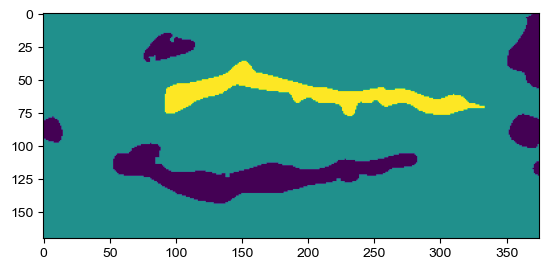

In [64]:
#plot the raster
plt.imshow(filled_raster, cmap='viridis')